<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Energy-Based Novelty</h1> 
</div>

<br/>

<p>
Following Section 6.1.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook an energy-based approach for computing a novelty curve.   
</p> 

## Local Energy Function

Often a note onset goes along with a sudden increase of the signal's energy. Based on this assumption, a straightforward way to detect note onsets is to transform the signal into a local energy function that indicates 
the local energy of the signal for each time instance and then to look for sudden changes in this function. Let $x:\mathbb{Z}\to\mathbb{R}$ be a [DT-signal](../C2/C2S2_DigitalSignalSampling.html). Furthermore, let $w:[-M:M]\to\mathbb{R}$ for some $M\in\mathbb{N}$ be a bell-shaped window function centered at time zero (e.g., a [Hann window](../C2/C2_STFT-Window.html)). The **local energy** of $x$ with regard to $w$ is defined to be the function $E_w^x:\mathbb{Z}\to\mathbb{R}$ given by 

\begin{equation}
 E_w^x(n) := \sum_{m=-M}^{M} |x(n+m)w(m)|^2 = \sum_{m\in\mathbb{Z}}|x(m)w(m-n)|^2
\end{equation}

In the following figures, we continue our Queen example "Another one bites the dust" (see the introductory [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html)).

<!--<img src="../data/C6/FMP_C6_F03_text.png" width="500px" align="middle" alt="FMP_C6_F03_text">-->

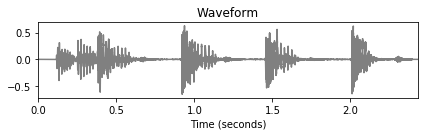

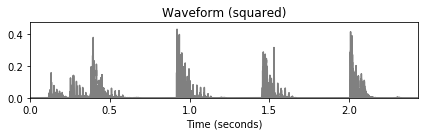

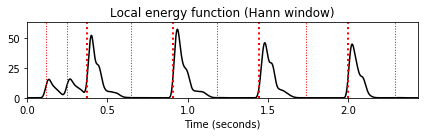

In [1]:
import numpy as np
import os, sys, librosa
import pandas as pd
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd

sys.path.append('..')
import LibFMP.B
import LibFMP.C2
import LibFMP.C6

%matplotlib inline

fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = LibFMP.C6.read_annotation_pos(fn_ann)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 
x_duration = len(x)/Fs

N = 2048
w = signal.hann(N)

#Calculate local energy
x_square = x**2
energy_local = np.convolve(x_square, w**2 , 'same')

LibFMP.B.plot_signal(x, Fs, title='Waveform')
LibFMP.B.plot_signal(x_square, Fs, title='Waveform (squared)')
fig, ax, line = LibFMP.B.plot_signal(energy_local, Fs, color='k', 
                    title='Local energy function (Hann window)')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

## Discrete Derivative and Half-Wave Rectification

To measure energy changes, we take a derivative of the local energy function. In the discrete case, the easiest way to realize such a derivative is to take the difference between two subsequent energy values. Furthermore, since we are interested in energy increases (and not decreases), we keep only the positive differences while setting the negative differences to zero. The latter step is known as **half-wave rectification** and is notated as: 

\begin{equation}
   |r|_{\geq 0} := \frac{r+|r|}{2} =
   \left\{\begin{array}{ll}
    r, &\,\, \mbox{if $r\geq 0$,}\\
    0, &\,\, \mbox{if $r< 0$,}
\end{array}\right.
\end{equation}

for $r\in\mathbb{R}$. Altogether, we obtain an **energy-based novelty function** $\Delta_\mathrm{Energy}:\mathrm{Z}\to\mathbb{R}$ given by 

\begin{equation}
   \Delta_\mathrm{Energy}(n):= |E_w^x(n+1)-E_w^x(n)|_{\geq 0}
\end{equation}

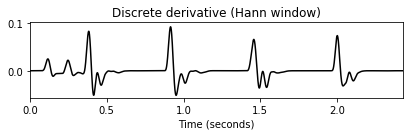

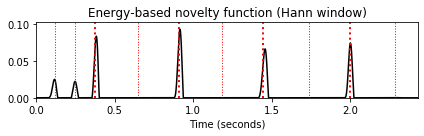

In [2]:
#Differentiation and half-wave rectification
energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
novelty_energy = np.copy(energy_local_diff)
novelty_energy[energy_local_diff < 0] = 0

LibFMP.B.plot_signal(energy_local_diff, Fs, color='k', 
                    title='Discrete derivative (Hann window)')
fig, ax, line = LibFMP.B.plot_signal(novelty_energy, Fs, color='k',
                    title='Energy-based novelty function (Hann window)')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

Note that this novelty function nicely indicates that the percussive beats contain a lot of energy. The low-energy hihat strokes in between, however, are not visible. Furthermore, note that the **smoothing effect** introduced by the bell-shaped Hann windowed is essential in this procedure when applying a simple framewise difference function. For example, using a [rectangular window](../C2/C2_STFT-Window.html) instead, the difference function reacts to small local fluctuations leading to a noisy energy function. This is demonstrated by the following figure.

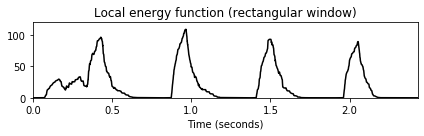

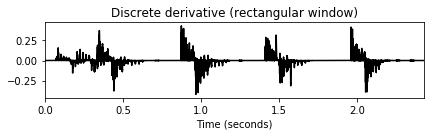

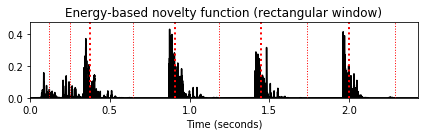

In [3]:
# Use rectangular window
w = signal.boxcar(N)
x_square = x**2
energy_local = np.convolve(x_square, w**2 , 'same')
energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
novelty_energy = np.copy(energy_local_diff)
novelty_energy[energy_local_diff < 0] = 0

fig, ax, line = LibFMP.B.plot_signal(energy_local, Fs, color='k',
                    title='Local energy function (rectangular window)')
LibFMP.B.plot_signal(energy_local_diff, Fs, color='k', 
                    title='Discrete derivative (rectangular window)')
fig, ax, line = LibFMP.B.plot_signal(novelty_energy, Fs, color='k', title='Energy-based novelty function (rectangular window)')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

## Logarithmic Compression

To account for the fact that human perception of sound intensity is logarithmic in nature,  one often applies a logarithm to the energy values, for example, by switching to the logarithmic decibel or by applying [logarithmic compression](../C3/C3S1_LogCompression.html). In the later case, we use the function $\Gamma_\gamma:\mathbb{R}_{>0} \to \mathbb{R}_{>0}$ defined by 

\begin{equation}
   \Gamma_\gamma(v):=\log(1+ \gamma \cdot v),
\end{equation}

where the positive constant $\gamma\in\mathbb{R}_{>0}$ regulates the degree of compression. The resulting novelty function is given by:

\begin{equation}
   \Delta_\mathrm{Energy}^\mathrm{Log}(n):= |\Gamma_\gamma(E_w^x(n+1))-\Gamma_\gamma(E_w^x(n))|_{\geq 0}.
\end{equation}

Besides the window length $N$, we introduce in the following implementation also a hope-size parameter $H$, which allows for decreasing the feature sampling rate of the computed novelty. Furthermore, dividing by its maximum value, we normalize the novelty function. In the next figure, continuing our running example, one can observe that some of the weak hihat onsets become visible (see $t=1.3~\mathrm{sec}$ and $t=2.3~\mathrm{sec}$) when using a logarithmic novelty function. As a downside of logarithmic compression, some noise-like sound components may be amplified, possibly leading to spurious peaks. As shown in this example, logarithmic compression also shifted some peak positions forward, now preceding the reference annotations (shown in red). This may indicate that the reference annotations, which were generated manually by a human listener, correspond to slightly delay "perceived" onset positions. 

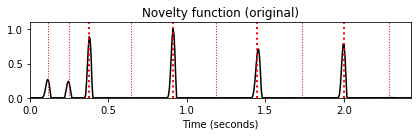

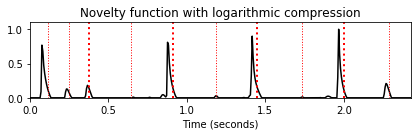

In [4]:
def compute_novelty_energy(x, Fs=1, N=2048, H=128, gamma=10, norm=1):
    """Compute energy-based novelty function 

    Notebook: C6/C6S1_NoveltyEnergy.ipynb

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hope size
        gamma: Parameter for logarithmic compression
        norm: Apply max norm (if norm==1)

    Returns:
        novelty_energy: Energy-based novelty function 
        Fs_feature: Feature rate
    """    
    x_power = x**2
    w = signal.hann(N)
    Fs_feature = Fs/H
    energy_local = np.convolve(x**2, w**2 , 'same')
    energy_local = energy_local[::H]
    if gamma!=None:
        energy_local = np.log(1 + gamma * energy_local)
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[energy_local_diff < 0] = 0
    if norm==1:
        max_value = max(novelty_energy)
        if max_value > 0:
            novelty_energy = novelty_energy / max_value
    return novelty_energy, Fs_feature

N = 2048
H = 128
nov_1, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=None)
nov_2, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=1000)

fig, ax, line = LibFMP.B.plot_signal(nov_1, Fs=Fs_nov, color='k', 
                    title='Novelty function (original)')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
fig, ax, line = LibFMP.B.plot_signal(nov_2, Fs=Fs_nov, color='k',
                    title='Novelty function with logarithmic compression')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

## Example: Note Onsets for Different Instruments

Another general problem in onset detection is energy fluctuation in nonsteady sounds as a result of vibrato or tremolo. Especially for purely energy-based procedures, amplitude modulations often lead to spurious peaks in the resulting novelty function. This is demonstrated by the following examples, which show the energy-based novelty function for the note C4 played by different instruments. While the novelty function shows a single clear peak in the case of a piano sound, there are many additional peaks in the case of a violin or flute sound. Furthermore, the relatively slow energy increase at the beginning of the violin sound my lead to a smeared and temporally inaccurate onset peak.

<!--<img src="../data/C6/FMP_C6_F04_text.png" width="600px" align="middle" alt="FMP_C6_F04_text">-->

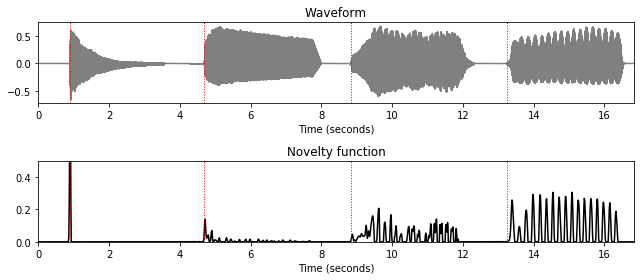

In [5]:
fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F04_NoteC4_PTVF.csv')
ann, label_keys = LibFMP.C6.read_annotation_pos(fn_ann, label='onset', header=0)

fn_wav = os.path.join('..', 'data', 'C6','FMP_C6_F04_NoteC4_PTVF.wav')
x, Fs = librosa.load(fn_wav)
x_duration = len(x)/Fs
N = 2048
H = 256
nov, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=None)

plt.figure(figsize=(9,4))
ax = plt.subplot(2,1,1)
fig, ax, line = LibFMP.B.plot_signal(x, Fs, ax = ax, title='Waveform')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration)

ax = plt.subplot(2,1,2)
fig, ax, line = LibFMP.B.plot_signal(nov, Fs=Fs_nov, ax = ax, color='k', 
                     title='Novelty function')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration)
plt.ylim([0, 0.5]);
plt.tight_layout()

<audio src="../data/C6/FMP_C6_F04_NoteC4_PTVF.mp3" type="audio/mpeg" controls="controls"></audio>

## Further Notes

* In the [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html), one finds an introduction to the task of onset detection. 
* In the [FMP notebook on novelty comparison](../C6/C6S1_NoveltyComparison.html), we compare different novelty detection approaches.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>